# Подключаем библиотеки

In [1]:
import pandas as pd # подключаем pandas
import numpy as np # numpy
import matplotlib.pyplot as plt # matplotlib для построения графиков
import seaborn as sns # seaborn еще одна библиотека для графиков
from sklearn.linear_model import LinearRegression # библиотека для создание модели линейной регрессии
from sklearn.tree import DecisionTreeRegressor # дерево решений для регрессии
from sklearn.svm import SVR # метод опорных векторов для регрессии
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error # метрики ошибок для регрессии
from sklearn.preprocessing import StandardScaler, MinMaxScaler # библиотеки для нормализации и масштабирования данных
from sklearn.model_selection import train_test_split # для разбиения датасета на обучающую и тестовую части
from sklearn.multioutput import MultiOutputRegressor # библиотека для множественной регрессии


# Загружаем датасет

In [2]:
data = pd.read_csv('ebw_data.csv') # загрузка датасета
data.head() # смотрим первые 5 строк в датасете

IW   IF   VW  FP  Depth  Width
0  47  139  4.5  80   1.60   2.54
1  47  139  4.5  80   1.62   2.50
2  47  139  4.5  80   1.68   2.60
3  47  139  4.5  80   1.58   2.52
4  45  140  4.5  80   1.76   2.48

In [3]:
data.info() # сводная информация датасета, смотрим если ли пропуски, какого типа данные, размер

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IW      72 non-null     int64  
 1   IF      72 non-null     int64  
 2   VW      72 non-null     float64
 3   FP      72 non-null     int64  
 4   Depth   72 non-null     float64
 5   Width   72 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 3.5 KB


In [4]:
data.shape # посмотрим размер датасета

(72, 6)

# Подготовка датасета

In [5]:
data.isna().sum() # Проверяем данные на пропуски. 

IW       0
IF       0
VW       0
FP       0
Depth    0
Width    0
dtype: int64

In [6]:
data.describe() # сводная статистика по данным

IW          IF         VW          FP      Depth      Width
count  72.000000   72.000000  72.000000   72.000000  72.000000  72.000000
mean   45.666667  141.333333   8.638889   78.333333   1.195556   1.970417
std     1.678363    5.145763   2.061078   21.493530   0.225081   0.279040
min    43.000000  131.000000   4.500000   50.000000   0.800000   1.680000
25%    44.000000  139.000000   8.000000   60.000000   1.080000   1.760000
50%    45.500000  141.000000   9.000000   80.000000   1.200000   1.840000
75%    47.000000  146.000000  10.000000   80.000000   1.290000   2.050000
max    49.000000  150.000000  12.000000  125.000000   1.760000   2.600000

Посмотрим на распределение данных и наличие выбросов построив график boxplot

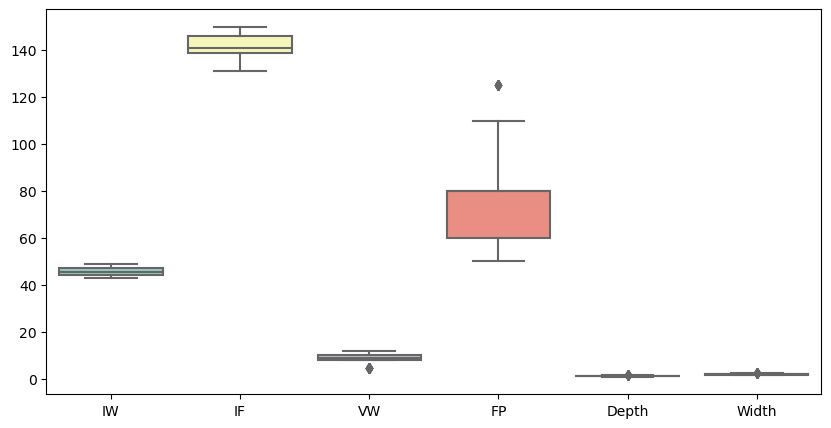

In [7]:
plt.figure(figsize=(10, 5))
sns.boxplot(data, palette='Set3')
plt.show()
# График получился не очень выразительный

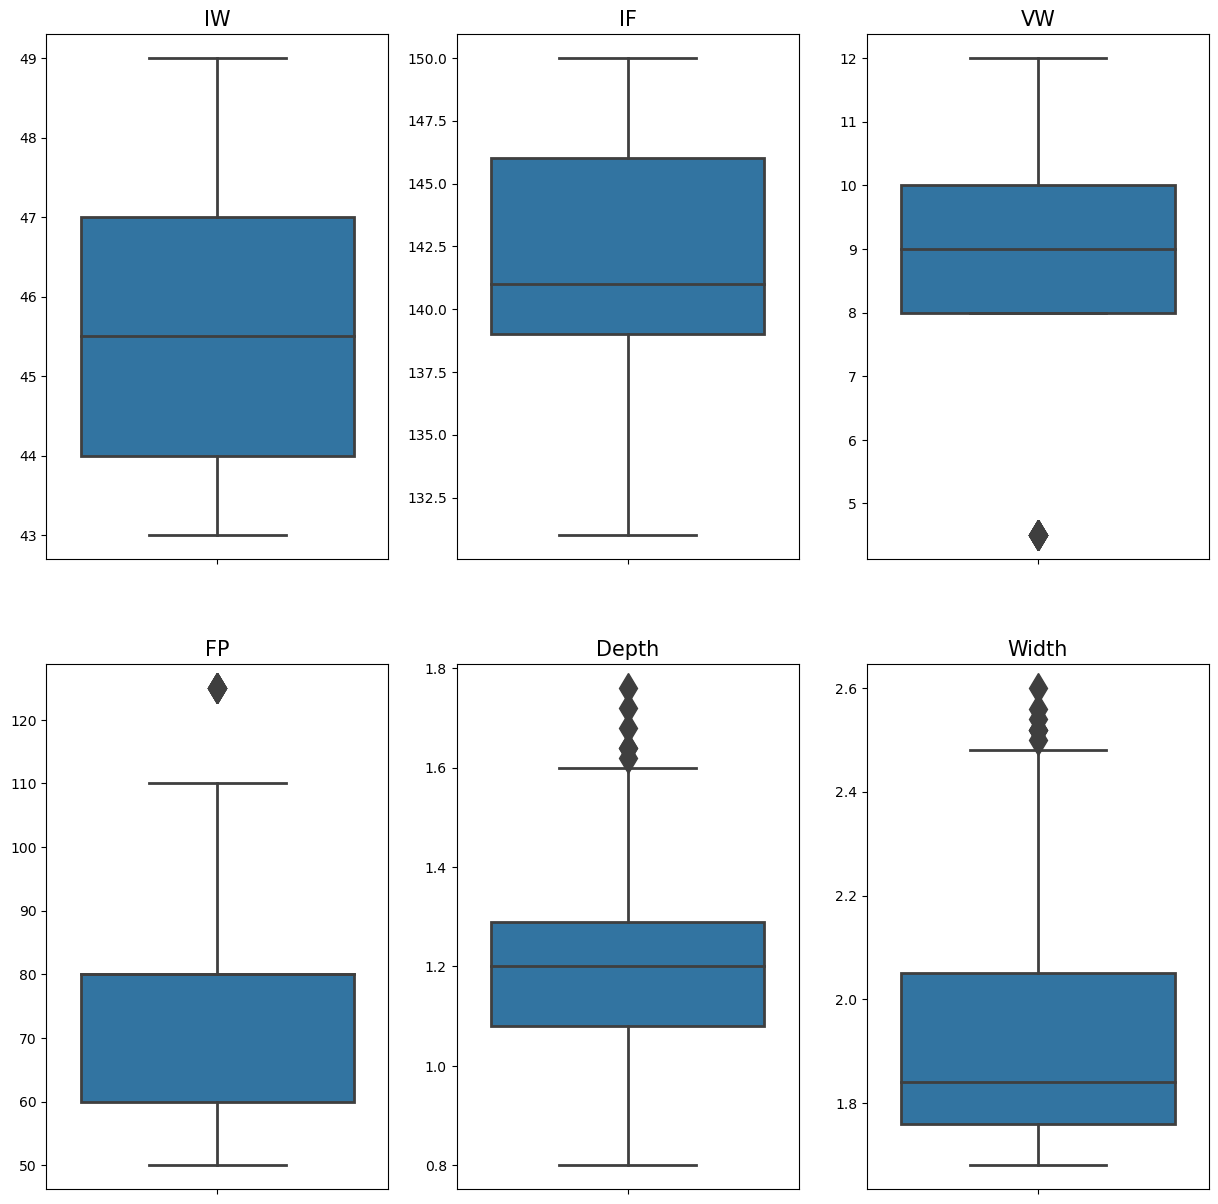

In [8]:
counter = 1

plt.figure(figsize=(15, 15))

for col in data.columns:
    plt.subplot(2, 3, counter)
    sns.boxplot(data=data, y=data[col], fliersize=15, linewidth=2)
    plt.ylabel(None)
    plt.title(col, size=15)
    counter += 1


На графике видим что распределение данных отличается от нормальных и присутствуют выбросы в некоторых признаках, а именно 'FP', 'VW' и в наличие выбросов в целевых признаках.

По хорошему нужно избавится от выбросов, но так как удаление выбросов ведет к потере данных, которых и так мало, то решаю оставить все как есть.

На графике pairplot можно увидеть наглядно как признаки зависят друг от друга.

c:\Users\qwwe\miniconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1000x500 with 0 Axes>

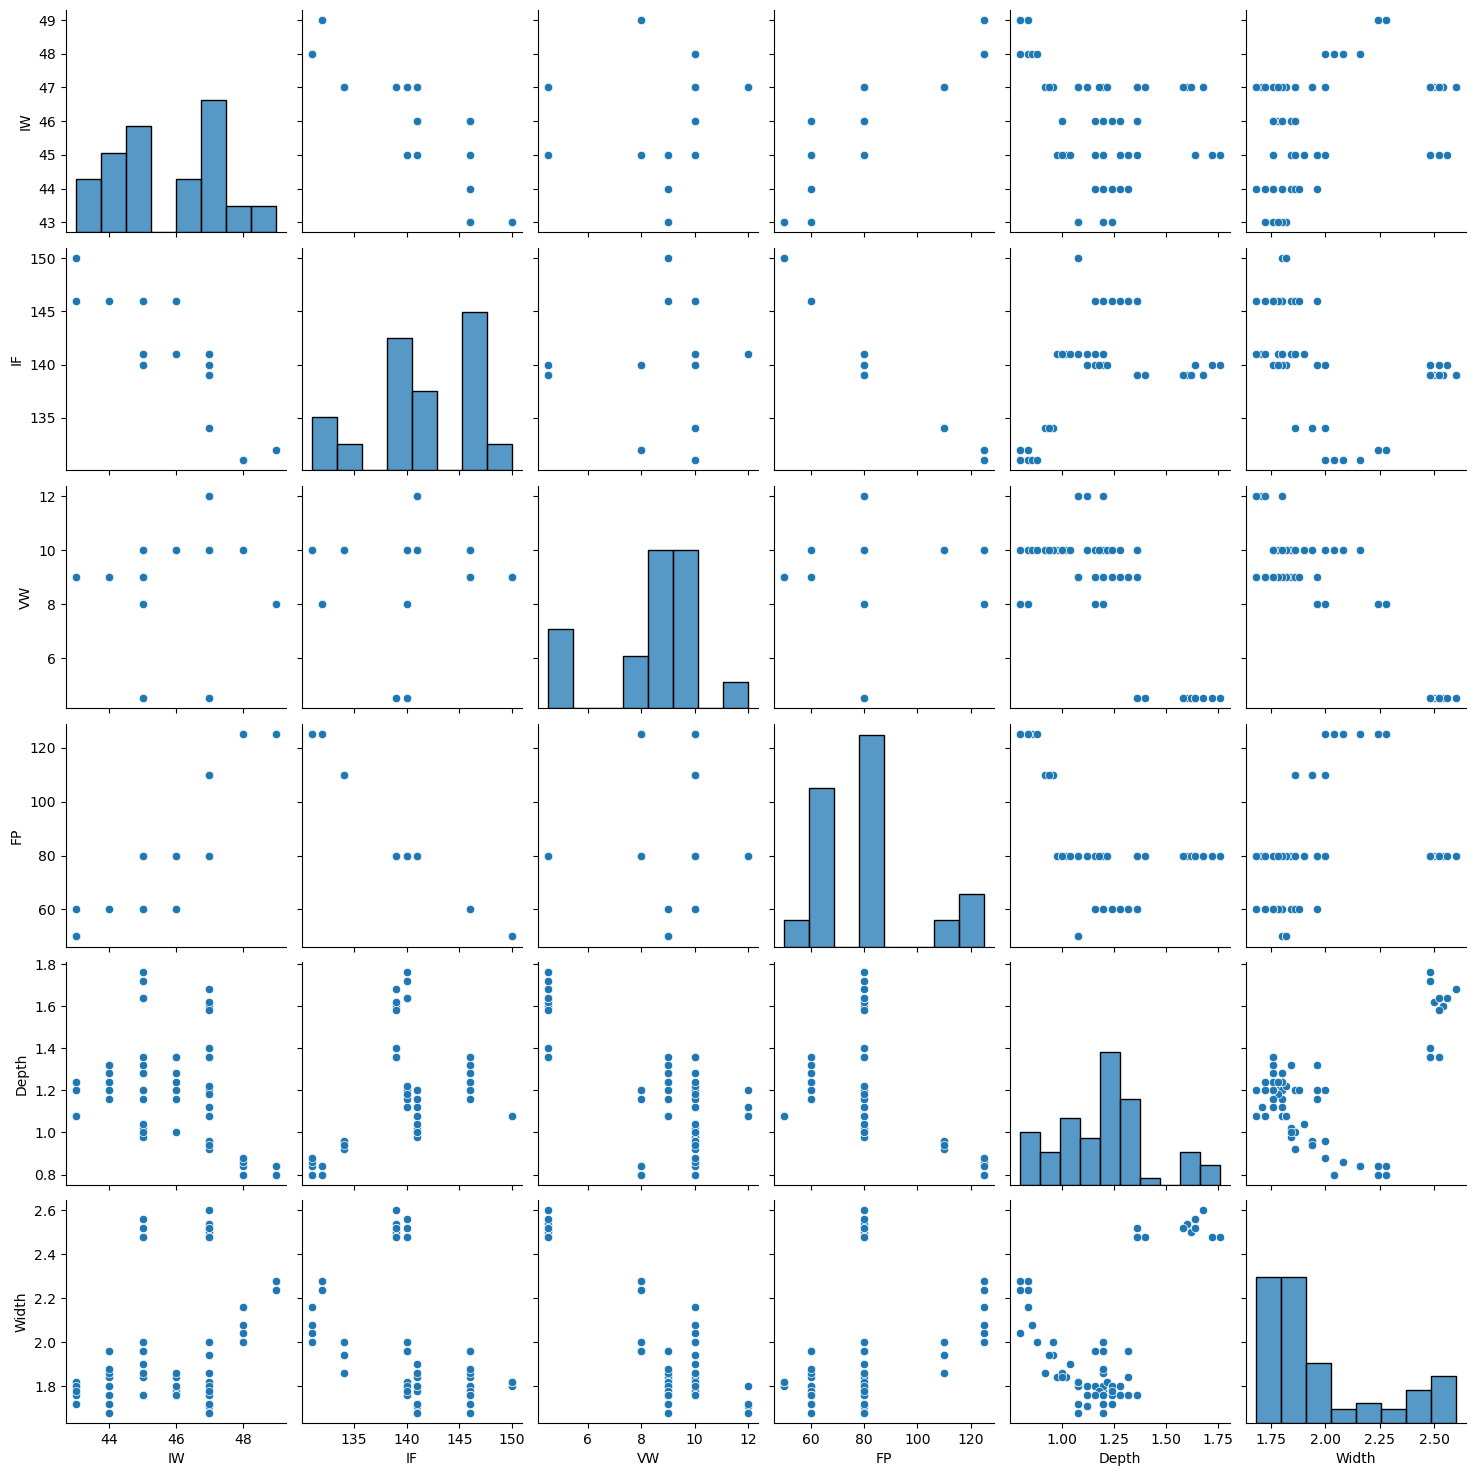

In [9]:
plt.figure(figsize=(10, 5))
sns.pairplot(data)
plt.show()

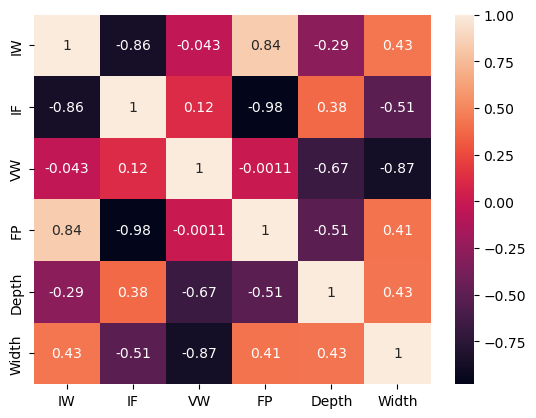

In [10]:
sns.heatmap(data.corr(), annot=True)
plt.show()

Нас интересует имеют ли корреляции целевые переменные 'Depth' и 'Width'. Обе целевые переменные имеют значительную корреляцию с признаками в особенности с признаком 'VW' -0.67 и -0.87, это явно указывает на линейную зависимость признака с целевыми переменными. Так что смысл что то удалять не имеет смысла.



Формируем выборку для дальнейшего обучения моделей

In [11]:
X = data.drop(['Depth', 'Width'], axis=1) # исследуемые данные
y = data[['Depth', 'Width']].copy() # целевые переменные

In [12]:
X.shape, y.shape

((72, 4), (72, 2))

Разбиваем данные на обучающие и тестовые в отношении 70% обучающая выборка и 30% тестовая выборка. Размер тестовой выборки 30% потому что данных немного если взять 20% обучатся будет не на чем слишком мало данных.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Масштабирование данных важно для алгоритма MultiOutputRegression, которым я буду использовать дальше, так как оно позволяет уравнять диапазоны значений для каждого выходного признака. Это важно, потому что разные выходные признаки могут иметь разные диапазоны значений, и это может затруднить обучение модели.

Например, если один выходной признак имеет диапазон значений от 0 до 1, а другой - от 100 до 1000, то модель может иметь проблемы с корректным обучением и прогнозированием. Масштабирование данных помогает уровнять эти диапазоны значений, делая их более сопоставимыми.

Кроме того, масштабирование данных может помочь улучшить производительность модели, так как оно может помочь избежать проблем сходимости алгоритма. Если данные не масштабированы, то градиенты оптимизационного алгоритма могут иметь различные масштабы, что может затруднить его сходимость.

В целом, масштабирование данных является важным шагом в предобработке данных для алгоритма MultiOutputRegression, чтобы достичь лучших результатов и повысить производительность модели.

In [14]:
minmax_scaler = MinMaxScaler()
X_train_scaled = minmax_scaler.fit_transform(X_train)
X_test_scaled = minmax_scaler.transform(X_test)

In [15]:
X_train_scaled.shape, y_train.shape

((50, 4), (50, 2))

In [16]:
X_test.shape, y_test.shape

((22, 4), (22, 2))

# Создание моделей

In [17]:
model_linear = MultiOutputRegressor(LinearRegression()) # создаем множественную модель линейной регрессии. Модель обучится методом линейной регрессии по каждому целевому признаку
model_tree = MultiOutputRegressor(DecisionTreeRegressor()) # обучаем модель алгоритмом дерево решений для задачи регрессии по каждому целевому признаку
model_svr = MultiOutputRegressor(SVR())

# Обучение моделей

In [18]:
model_linear.fit(X_train_scaled, y_train)
model_tree.fit(X_train_scaled, y_train)
model_svr.fit(X_train_scaled, y_train)

MultiOutputRegressor(estimator=SVR())

Делаем предсказания значений по обученным моделям

In [19]:
y_pred_lr = model_linear.predict(X_test_scaled)
y_pred_dtr = model_tree.predict(X_test_scaled)
y_pred_svr = model_svr.predict(X_test_scaled)

In [20]:
y_pred_lr.shape, y_pred_dtr.shape, y_pred_svr.shape # проверяем размер полученных данных на всякий случай

((22, 2), (22, 2), (22, 2))

In [21]:
y_pred_lr.mean(axis=0) # предсказанное среднее значение полученное моделью линейной регрессии

array([1.21471137, 1.91860777])

In [22]:
y_pred_dtr.mean(axis=0) # предсказанное среднее значение полученное моделью дерево решений

array([1.18430303, 1.93269697])

In [23]:
y_pred_svr.mean(axis=0) # предсказанное среднее значение полученное моделью svr

array([1.2044224 , 1.96587555])

# Оценка моделей

## Средняя абсолютная ошибка (MAE)

Чем ближе к 0 тем точнее предсказанные модели.

In [24]:
print('Средняя абсолютная ошибка модели LinearRegression:', mae_lr := mean_absolute_error(
    y_test, y_pred_lr, multioutput='raw_values'))
print('Средняя абсолютная ошибка модели DecisionTreeRegressor:', mae_dtr := mean_absolute_error(
    y_test, y_pred_dtr, multioutput='raw_values'))
print('Средняя абсолютная ошибка модели SVR:', mae_svr :=
      mean_absolute_error(y_test, y_pred_svr, multioutput='raw_values'))


Средняя абсолютная ошибка модели LinearRegression: [0.09145654 0.06951726]
Средняя абсолютная ошибка модели DecisionTreeRegressor: [0.0549697  0.03792424]
Средняя абсолютная ошибка модели SVR: [0.06454959 0.05772897]


## Среднеквадратичная ошибка (MSE)



In [25]:
print('Среднеквадратичная ошибка модели LinearRegression:', mse_lr := mean_squared_error(y_test, y_pred_lr, multioutput='raw_values'))
print('Среднеквадратичная ошибка модели DecisionTreeRegressor:',
      mse_dtr := mean_squared_error(y_test, y_pred_dtr, multioutput='raw_values'))
print('Среднеквадратичная ошибка модели SVR:',
      mse_svr := mean_squared_error(y_test, y_pred_svr, multioutput='raw_values'))



Среднеквадратичная ошибка модели LinearRegression: [0.01244552 0.00704678]
Среднеквадратичная ошибка модели DecisionTreeRegressor: [0.00566147 0.00257683]
Среднеквадратичная ошибка модели SVR: [0.00583682 0.00471874]


## Коэффициент детерминации $R^2$

In [26]:
print('Коэффициент детерминации модели LinearRegression:',r2_lr := r2_score(y_test, y_pred_lr, multioutput='raw_values'))
print('Коэффициент детерминации модели DecisionTreeRegressor:',r2_dtr := r2_score(y_test, y_pred_dtr, multioutput='raw_values'))
print('Коэффициент детерминации модели SVR:',r2_svr := r2_score(y_test, y_pred_svr, multioutput='raw_values'))

Коэффициент детерминации модели LinearRegression: [0.57214867 0.88344828]
Коэффициент детерминации модели DecisionTreeRegressor: [0.80537022 0.95737991]
Коэффициент детерминации модели SVR: [0.79934222 0.92195331]


In [27]:
df_res = pd.DataFrame({
    'LinearRegression': {'MSE_Depth': mse_lr[0],
                         'MSE_Width': mse_lr[1],
                         'MAE_Depth': mae_lr[0],
                         'MAE_Width': mae_lr[1],
                         'r2_Depth': r2_lr[0],
                         'r2_Width': r2_lr[1]},
    'DecisionTreeRegressor': {'MSE_Depth': mse_dtr[0],
                              'MSE_Width': mse_dtr[1],
                              'MAE_Depth': mae_dtr[0],
                              'MAE_Width': mae_dtr[1],
                              'r2_Depth': r2_dtr[0],
                              'r2_Width': r2_dtr[1]},
    'SVR': {'MSE_Depth': mse_svr[0],
            'MSE_Width': mse_svr[1],
            'MAE_Depth': mae_svr[0],
            'MAE_Width': mae_svr[1],
            'r2_Depth': r2_svr[0],
            'r2_Width': r2_svr[1]}
})

df_res


LinearRegression  DecisionTreeRegressor       SVR
MSE_Depth          0.012446               0.005661  0.005837
MSE_Width          0.007047               0.002577  0.004719
MAE_Depth          0.091457               0.054970  0.064550
MAE_Width          0.069517               0.037924  0.057729
r2_Depth           0.572149               0.805370  0.799342
r2_Width           0.883448               0.957380  0.921953

В итоге модель Дерево решений дала самый лучший результат с наименьшими ошибками и коэффициент детерминации близок к 1

## Нейронная сеть

In [28]:

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense


In [29]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [30]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(50, 4)
(22, 4)


In [31]:
dnn_model = Sequential() 
dnn_model.add(layers.Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
dnn_model.add(layers.Dense(32, activation='relu'))  
dnn_model.add(layers.Dense(16, activation='relu')) 
dnn_model.add(layers.Dense(2, activation='linear'))  

dnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

dnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 2962 (11.57 KB)
Trainable params: 2962 (11.57 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
history = dnn_model.fit(
    X_train_scaled,
    y_train,
    validation_split=0.2,
    verbose=1,  
    epochs=200
    )


Epoch 1/200
2/2 [==============================] - 1s 130ms/step - loss: 2.9257 - mae: 1.6674 - val_loss: 2.6653 - val_mae: 1.5903
Epoch 2/200
2/2 [==============================] - 0s 20ms/step - loss: 2.7429 - mae: 1.6157 - val_loss: 2.5261 - val_mae: 1.5501
Epoch 3/200
2/2 [==============================] - 0s 20ms/step - loss: 2.5602 - mae: 1.5624 - val_loss: 2.3933 - val_mae: 1.5106
Epoch 4/200
2/2 [==============================] - 0s 20ms/step - loss: 2.3966 - mae: 1.5111 - val_loss: 2.2655 - val_mae: 1.4709
Epoch 5/200
2/2 [==============================] - 0s 20ms/step - loss: 2.2244 - mae: 1.4552 - val_loss: 2.1325 - val_mae: 1.4276
Epoch 6/200
2/2 [==============================] - 0s 30ms/step - loss: 2.0582 - mae: 1.3973 - val_loss: 2.0008 - val_mae: 1.3833
Epoch 7/200
2/2 [==============================] - 0s 20ms/step - loss: 1.8910 - mae: 1.3358 - val_loss: 1.8667 - val_mae: 1.3359
Epoch 8/200
2/2 [==============================] - 0s 20ms/step - loss: 1.7266 - mae: 1.2

In [33]:
dnn_model.evaluate(X_train_scaled, y_train)

2/2 [==============================] - 0s 3ms/step - loss: 0.0035 - mae: 0.0459


[0.0034807913471013308, 0.04588286578655243]

In [34]:
dnn_model.evaluate(X_test_scaled, y_test)


1/1 [==============================] - 0s 18ms/step - loss: 0.0048 - mae: 0.0545


[0.0048284935764968395, 0.05449642986059189]

In [35]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='test loss')
    plt.xlabel('Эпоха')
    plt.ylabel('MAE')
    plt.legend()
    plt.grid(True)


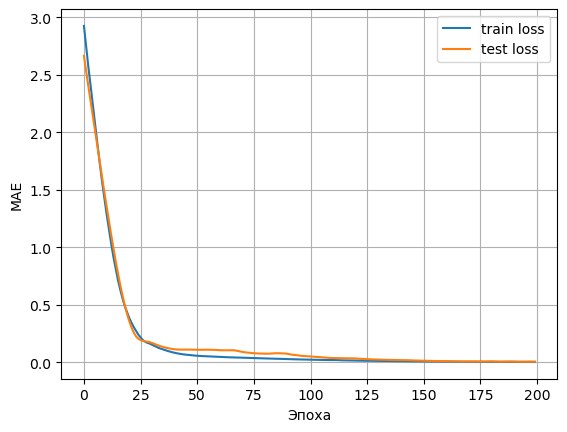

In [36]:
plot_loss(history)
plt.show()


In [37]:
prediction = dnn_model.predict(X_test_scaled)


1/1 [==============================] - 0s 71ms/step


In [38]:
X_test_scaled[0]

array([-0.48507125,  0.03595143,  0.70067935, -0.01847344])

In [39]:
prediction.mean(axis=0)

array([1.2097011, 1.9415169], dtype=float32)

In [40]:
y_test.mean(axis=0)

Depth    1.184545
Width    1.925909
dtype: float64

In [41]:
print('mse: ', mean_squared_error(prediction, y_test, multioutput='raw_values'))
print('mae: ', mean_absolute_error(prediction, y_test, multioutput='raw_values'))
print('r^2: ', r2_score(prediction, y_test, multioutput='raw_values'))


mse:  [0.00674164 0.00291534]
mae:  [0.06560506 0.04338779]
r^2:  [0.79353904 0.95578771]


In [42]:
X_test.head(1)

IW   IF    VW  FP
14  45  141  10.0  80

## Сохраняем модель

In [43]:
# сохраняем модель нейронной сети
dnn_model.save('dnn_model') 

INFO:tensorflow:Assets written to: dnn_model\assets


INFO:tensorflow:Assets written to: dnn_model\assets


In [50]:
# сохранение параметров нормализации
np.save('scaler_mean.npy', scaler.mean_)
np.save('scaler_std.npy', scaler.scale_)

In [44]:
# Загружаем модель нейронной сети
dnn_model_loaded = keras.models.load_model('dnn_model')

In [45]:
# делаем предсказания загруженной модели
dnn_model_loaded.predict(X_test_scaled)


1/1 [==============================] - 0s 41ms/step


array([[1.0978168, 1.910156 ],
       [1.5616807, 2.552457 ],
       [1.5616807, 2.552457 ],
       [1.2283571, 1.8084197],
       [1.1682929, 1.8142636],
       [1.1298358, 1.754338 ],
       [1.1722893, 1.7817583],
       [1.2268765, 1.9354835],
       [1.2997171, 1.8086717],
       [1.5616807, 2.552457 ],
       [1.2063891, 1.8126895],
       [1.2283571, 1.8084197],
       [1.1042715, 1.7695847],
       [1.2268765, 1.9354835],
       [0.8325653, 2.0625854],
       [1.1682929, 1.8142636],
       [1.2765973, 1.7766136],
       [1.1682929, 1.8142636],
       [0.8325653, 2.0625854],
       [1.2283571, 1.8084197],
       [1.2283571, 1.8084197],
       [1.1042715, 1.7695847]], dtype=float32)

In [46]:
# подгружаем библиотеку для сохранения линейной модели
import pickle

In [47]:
# сохраняем модель дерево решений
pickle.dump(model_tree, open('dtr_model.pkl', 'wb'))


In [48]:
# загрузка модели дерево решений
model_load = pickle.load(open('dtr_model.pkl', 'rb'))

In [49]:
# Предсказания линейной модели
model_load.predict(X_test_scaled)

array([[1.08      , 1.84666667],
       [1.516     , 2.532     ],
       [1.516     , 2.532     ],
       [1.69      , 2.51      ],
       [1.69      , 2.51      ],
       [1.08      , 1.84666667],
       [1.29333333, 1.8       ],
       [1.516     , 2.532     ],
       [1.69      , 2.51      ],
       [1.516     , 2.532     ],
       [1.69      , 2.51      ],
       [1.69      , 2.51      ],
       [1.29333333, 1.7       ],
       [1.516     , 2.532     ],
       [0.83      , 2.06      ],
       [1.69      , 2.51      ],
       [1.08      , 1.8075    ],
       [1.69      , 2.51      ],
       [0.83      , 2.06      ],
       [1.69      , 2.51      ],
       [1.69      , 2.51      ],
       [1.29333333, 1.7       ]])